In [ ]:
import boto3
import os
import glob
from botocore import UNSIGNED
from botocore.config import Config
import xarray
import cfgrib

model = 'HARMONIE_DINI_SF'
model_run = '2025-03-11T000000Z'
modeldir = 'modeldir'

# Create the model directory if it does not exist
os.makedirs(modeldir, exist_ok=True)

# Initialize the S3 client
config = Config(signature_version=UNSIGNED)
s3 = boto3.client('s3', region_name='eu-north-1', config=config)

# Bucket where modelfiles are located
bucket_name = 'dmi-opendata'

# List objects in the bucket that match the model and modelrun
response = s3.list_objects_v2(Bucket=bucket_name, Prefix="forecastdata/"+model+"/"+model + "_" + model_run)

# Check if the bucket contains any files
if 'Contents' in response:
    for obj in response['Contents']:
        key = obj['Key']
        localfile = key.split('/')[-1]
        downloaded_already = os.path.exists(os.path.join(modeldir, localfile))
        if model + "_" + model_run in key and not downloaded_already:
            print(f'Downloading {key}...')
            # Download the file
            s3.download_file(bucket_name, key, os.path.join(modeldir, localfile))
            print(f'{key} downloaded successfully.')
else:
    print('No files found in the bucket.')



In [ ]:
# Find all files in the modelrun (which should not include index files)
forecast_files = glob.glob(modeldir+"/"+model + "_" + model_run+'*.grib')
forecast_files.sort()
# Show modelfile content
cfgrib_dataset = cfgrib.open_datasets(forecast_files[0], decode_timedelta=False)
print(cfgrib_dataset)


[<xarray.Dataset> Size: 61MB
Dimensions:                (y: 1606, x: 1906)
Coordinates:
    number                 int64 8B 0
    time                   datetime64[ns] 8B 2025-03-11
    step                   float64 8B 0.0
    adiabaticCondensation  float64 8B 0.0
    latitude               (y, x) float64 24MB ...
    longitude              (y, x) float64 24MB ...
    valid_time             datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables:
    h                      (y, x) float32 12MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ekmi
    GRIB_centreDescription:  Copenhagen
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Copenhagen, <xarray.Dataset> Size: 61MB
Dimensions:     (y: 1606, x: 1906)
Coordinates:
    number      int64 8B 0
    time        datetime64[ns] 8B 2025-03-11
    step        float64 8B 0.0
    cloudTop    float64 8B 0.0
    latitude    (y, x) float64 24MB ...
  

In [ ]:
# Open the forecast files using xarray and show the dataset
import dask
dataset = xarray.open_mfdataset(forecast_files, engine="cfgrib", combine = 'nested', concat_dim ='valid_time', backend_kwargs={'filter_by_keys': {'shortName': '2t'}}, decode_timedelta=False)
dataset

<xarray.Dataset> Size: 796MB
Dimensions:            (valid_time: 61, y: 1606, x: 1906)
Coordinates:
    number             int64 8B 0
    time               datetime64[ns] 8B 2025-03-11
    step               (valid_time) float64 488B 0.0 1.0 2.0 ... 58.0 59.0 60.0
    heightAboveGround  float64 8B 2.0
    latitude           (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
    longitude          (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
  * valid_time         (valid_time) datetime64[ns] 488B 2025-03-11 ... 2025-0...
Dimensions without coordinates: y, x
Data variables:
    t2m                (valid_time, y, x) float32 747MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ekmi
    GRIB_centreDescription:  Copenhagen
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Copenhagen
    history:                 2025-03-11T22:40 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
# Show information about a single variable
dataset['t2m']

<xarray.DataArray 't2m' (valid_time: 61, y: 1606, x: 1906)> Size: 747MB
dask.array<concatenate, shape=(61, 1606, 1906), dtype=float32, chunksize=(1, 1606, 1906), chunktype=numpy.ndarray>
Coordinates:
    number             int64 8B 0
    time               datetime64[ns] 8B 2025-03-11
    step               (valid_time) float64 488B 0.0 1.0 2.0 ... 58.0 59.0 60.0
    heightAboveGround  float64 8B 2.0
    latitude           (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
    longitude          (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
  * valid_time         (valid_time) datetime64[ns] 488B 2025-03-11 ... 2025-0...
Dimensions without coordinates: y, x
Attributes: (12/35)
    GRIB_paramId:                             167
    GRIB_dataType:                            cf
    GRIB_numberOfPoints:                      3061036
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           2t
    GRIB_totalNumber:                         31
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature

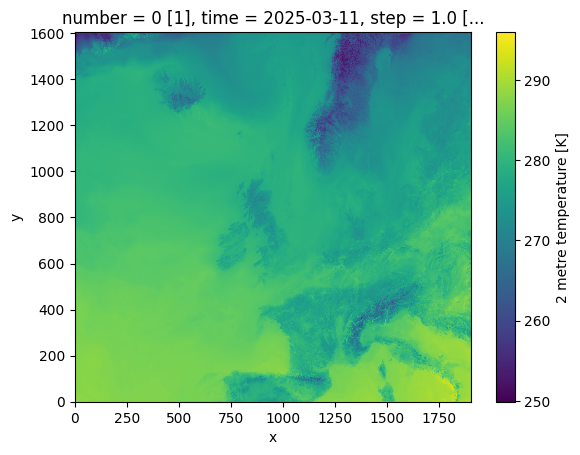

In [ ]:
# Plot a single timestep
dataset['t2m'].isel(valid_time=1).plot()


In [1]:
# Plot out all timesteps in the model run
# Commented out to keep guide small

# import matplotlib.pyplot as plt
# for valid_time_idx in range(0,len(dataset.valid_time)):
#     dataset['t2m'].isel(valid_time=valid_time_idx).plot()
#     plt.show()
